<a href="https://colab.research.google.com/github/sergiopaniego/BehaviorStudio-experiments/blob/main/trained_networks_comparison_to_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/curves_only.zip"
!unzip "/content/drive/My Drive/complete_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: complete_dataset/Images/4655.png  
  inflating: complete_dataset/Images/13432.png  
  inflating: complete_dataset/Images/13393.png  
  inflating: complete_dataset/Images/14645.png  
  inflating: complete_dataset/Images/16896.png  
  inflating: complete_dataset/Images/4638.png  
  inflating: complete_dataset/Images/12695.png  
  inflating: complete_dataset/Images/13074.png  
  inflating: complete_dataset/Images/16020.png  
  inflating: complete_dataset/Images/15454.png  
  inflating: complete_dataset/Images/690.png  
  inflating: complete_dataset/Images/8168.png  
  inflating: complete_dataset/Images/4244.png  
  inflating: complete_dataset/Images/16078.png  
  inflating: complete_dataset/Images/6062.png  
  inflating: complete_dataset/Images/7468.png  
  inflating: complete_dataset/Images/1326.png  
  inflating: complete_dataset/Images/2106.png  
  inflating: complete_dataset/Images/585.png  
  inflating: complete_dataset/

In [ ]:
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


def load_data(folder):
    name_folder = '/content/' + folder + '/Images/'
    list_images = glob.glob(name_folder + '*')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[4].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    file = open(name_file, 'r')
    data = file.read()
    file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    data_parse = data.split('}')[:-1]
    for d in data_parse:
        v = d.split('"v": ')[1]
        d_parse = d.split(', "v":')[0]
        w = d_parse.split(('"w": '))[1]
        array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('complete_dataset')
images_curve, data_curve = load_data('curves_only')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
array_imgs = get_images(images_curve, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)
array_annotations = parse_json(data_curve, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
  array_annotations_v.append(annotation[0])
  array_annotations_w.append(annotation[1])
  
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
# normalized_Y = normalize(array_annotations_w)
old_min = array_annotations_w.min()
old_range = array_annotations_w.max() - old_min

new_min = -1
new_range = 2
normalized_Y = [(n - old_min) / old_range * new_range + new_min for n in array_annotations_w]
normalized_Y = np.array(normalized_Y)

normalized_annotations = []
for i in range(0, len(normalized_X)):
  normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA

split_test_train_value = 0.30
#images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_imgs, array_annotations, test_size=0.30, random_state=42)
# FOR LSTMs -> suffle=False because the order of images is relevant
images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_imgs, array_annotations, test_size=split_test_train_value, random_state=42, shuffle=False)
#images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_2_images, array_annotations, test_size=0.30, random_state=42)

# Adapt the data
images_train = np.stack(images_train, axis=0)
annotations_train = np.stack(annotations_train, axis=0)
images_validation = np.stack(images_validation, axis=0)
annotations_validation = np.stack(annotations_validation, axis=0)

print(annotations_train[0])
print(annotations_train.shape)

#video = np.stack(array_imgs, axis=0)
print(images_train.shape)
print(images_validation.shape)


['/content/complete_dataset/Images/2215.png', '/content/complete_dataset/Images/15274.png', '/content/complete_dataset/Images/2200.png', '/content/complete_dataset/Images/2133.png', '/content/complete_dataset/Images/14460.png', '/content/complete_dataset/Images/9088.png', '/content/complete_dataset/Images/16074.png', '/content/complete_dataset/Images/7420.png', '/content/complete_dataset/Images/3094.png', '/content/complete_dataset/Images/15031.png', '/content/complete_dataset/Images/3819.png', '/content/complete_dataset/Images/8760.png', '/content/complete_dataset/Images/2867.png', '/content/complete_dataset/Images/14976.png', '/content/complete_dataset/Images/9041.png', '/content/complete_dataset/Images/9154.png', '/content/complete_dataset/Images/16158.png', '/content/complete_dataset/Images/16781.png', '/content/complete_dataset/Images/1240.png', '/content/complete_dataset/Images/4641.png', '/content/complete_dataset/Images/10187.png', '/content/complete_dataset/Images/13951.png', 

In [ ]:
!ls "/content/drive/My Drive"
!unzip "/content/drive/My Drive/many_curves_dataset.zip"

 20210215-134322_model_lstm_sequence_test_cp.h5
 20210215-134322_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test_cp.h5
 20210215-134625_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence_cp.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.csv
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.h5
 20210216-084753_tinypilotnet_lstm_model_sequence_cp.h5
 20210216-084753_tinypilotnet_lstm_model_sequence.csv
 20210216-084753_tinypilotnet_lstm_model_sequence.h5
 20210216-091101_tinypilotnet_model_sequence_cp.h5
 20210216-091101_tinypilotnet_model_sequence.csv
 20210216-091101_tinypilotnet_model_sequence.h5
 20210216-095459_pilotnet_model_model_sequence_cp.h5
 20210216-095459_pilotnet_model_model_sequence.csv
 20210216-095459_pilotnet_model_model_sequence.h5
 20210219-082603_deepest_lstm_tinypilotnet_model_RGB_sequence_cp.h5
 20210219-082603_deepest_lstm_tinypilotnet_mode

In [ ]:
import json
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def load_data(folder):
    name_folder = '/content/' + folder + '/'
    list_images = glob.glob(name_folder + '*.png')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[3].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    json_file = open(name_file, 'r')
    data = json.load(json_file)
    json_file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    for key, value in data.items():
      v = data[key]['v']
      w = data[key]['w']
      array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('many_curves_dataset')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
  array_annotations_v.append(annotation[0])
  array_annotations_w.append(annotation[1])
  
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
# normalized_Y = normalize(array_annotations_w)
old_min = array_annotations_w.min()
old_range = array_annotations_w.max() - old_min

new_min = -1
new_range = 2
normalized_Y = [(n - old_min) / old_range * new_range + new_min for n in array_annotations_w]
normalized_Y = np.array(normalized_Y)

normalized_annotations = []
for i in range(0, len(normalized_X)):
  normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA


# Adapt the data
images_many_curves = np.stack(array_imgs, axis=0)
annotations_many_curves = np.stack(array_annotations, axis=0)

print(images_many_curves.shape)
print(annotations_many_curves.shape)

['/content/many_curves_dataset/2215.png', '/content/many_curves_dataset/2200.png', '/content/many_curves_dataset/2133.png', '/content/many_curves_dataset/1240.png', '/content/many_curves_dataset/16.png', '/content/many_curves_dataset/1436.png', '/content/many_curves_dataset/1139.png', '/content/many_curves_dataset/1434.png', '/content/many_curves_dataset/1556.png', '/content/many_curves_dataset/1799.png', '/content/many_curves_dataset/2671.png', '/content/many_curves_dataset/1235.png', '/content/many_curves_dataset/277.png', '/content/many_curves_dataset/2259.png', '/content/many_curves_dataset/359.png', '/content/many_curves_dataset/386.png', '/content/many_curves_dataset/2666.png', '/content/many_curves_dataset/1449.png', '/content/many_curves_dataset/725.png', '/content/many_curves_dataset/2096.png', '/content/many_curves_dataset/801.png', '/content/many_curves_dataset/673.png', '/content/many_curves_dataset/863.png', '/content/many_curves_dataset/2153.png', '/content/many_curves_da

In [ ]:
!ls "/content/drive/My Drive"
!unzip "/content/drive/My Drive/simple_circuit_dataset.zip"

 20210215-134322_model_lstm_sequence_test_cp.h5
 20210215-134322_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test_cp.h5
 20210215-134625_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence_cp.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.csv
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.h5
 20210216-084753_tinypilotnet_lstm_model_sequence_cp.h5
 20210216-084753_tinypilotnet_lstm_model_sequence.csv
 20210216-084753_tinypilotnet_lstm_model_sequence.h5
 20210216-091101_tinypilotnet_model_sequence_cp.h5
 20210216-091101_tinypilotnet_model_sequence.csv
 20210216-091101_tinypilotnet_model_sequence.h5
 20210216-095459_pilotnet_model_model_sequence_cp.h5
 20210216-095459_pilotnet_model_model_sequence.csv
 20210216-095459_pilotnet_model_model_sequence.h5
 20210219-082603_deepest_lstm_tinypilotnet_model_RGB_sequence_cp.h5
 20210219-082603_deepest_lstm_tinypilotnet_mode

In [ ]:
import json
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def load_data(folder):
    name_folder = '/content/' + folder + '/'
    list_images = glob.glob(name_folder + '*.png')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[3].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    json_file = open(name_file, 'r')
    data = json.load(json_file)
    json_file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    for key, value in data.items():
      v = data[key]['v']
      w = data[key]['w']
      array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('simple_circuit_dataset')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
  array_annotations_v.append(annotation[0])
  array_annotations_w.append(annotation[1])
  
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
# normalized_Y = normalize(array_annotations_w)
old_min = array_annotations_w.min()
old_range = array_annotations_w.max() - old_min

new_min = -1
new_range = 2
normalized_Y = [(n - old_min) / old_range * new_range + new_min for n in array_annotations_w]
normalized_Y = np.array(normalized_Y)

normalized_annotations = []
for i in range(0, len(normalized_X)):
  normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA


# Adapt the data
images_simple = np.stack(array_imgs, axis=0)
annotations_simple = np.stack(array_annotations, axis=0)

print(images_simple.shape)
print(annotations_simple.shape)

['/content/simple_circuit_dataset/1240.png', '/content/simple_circuit_dataset/16.png', '/content/simple_circuit_dataset/1436.png', '/content/simple_circuit_dataset/1139.png', '/content/simple_circuit_dataset/1434.png', '/content/simple_circuit_dataset/1556.png', '/content/simple_circuit_dataset/1235.png', '/content/simple_circuit_dataset/277.png', '/content/simple_circuit_dataset/359.png', '/content/simple_circuit_dataset/386.png', '/content/simple_circuit_dataset/1449.png', '/content/simple_circuit_dataset/725.png', '/content/simple_circuit_dataset/801.png', '/content/simple_circuit_dataset/673.png', '/content/simple_circuit_dataset/863.png', '/content/simple_circuit_dataset/535.png', '/content/simple_circuit_dataset/568.png', '/content/simple_circuit_dataset/598.png', '/content/simple_circuit_dataset/1750.png', '/content/simple_circuit_dataset/539.png', '/content/simple_circuit_dataset/1058.png', '/content/simple_circuit_dataset/1095.png', '/content/simple_circuit_dataset/153.png', '

In [ ]:
!ls "/content/drive/My Drive"
!unzip "/content/drive/My Drive/montmelo_data.zip"

 20210215-134322_model_lstm_sequence_test_cp.h5
 20210215-134322_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test_cp.h5
 20210215-134625_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence_cp.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.csv
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.h5
 20210216-084753_tinypilotnet_lstm_model_sequence_cp.h5
 20210216-084753_tinypilotnet_lstm_model_sequence.csv
 20210216-084753_tinypilotnet_lstm_model_sequence.h5
 20210216-091101_tinypilotnet_model_sequence_cp.h5
 20210216-091101_tinypilotnet_model_sequence.csv
 20210216-091101_tinypilotnet_model_sequence.h5
 20210216-095459_pilotnet_model_model_sequence_cp.h5
 20210216-095459_pilotnet_model_model_sequence.csv
 20210216-095459_pilotnet_model_model_sequence.h5
 20210219-082603_deepest_lstm_tinypilotnet_model_RGB_sequence_cp.h5
 20210219-082603_deepest_lstm_tinypilotnet_mode

In [ ]:
import json
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def load_data(folder):
    name_folder = '/content/' + folder + '/'
    list_images = glob.glob(name_folder + '*.jpg')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[3].split('.jpg')[0]))
    name_file = '/content/' + folder + '/data.json'
    json_file = open(name_file, 'r')
    data = json.load(json_file)
    json_file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    for key, value in enumerate(data):
      v = data[key]['v']
      w = data[key]['w']
      array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('montmelo_data')
print(images)
print(data)

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
print(images)
print(array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)
print(array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
  array_annotations_v.append(annotation[0])
  array_annotations_w.append(annotation[1])
  
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
# normalized_Y = normalize(array_annotations_w)
old_min = array_annotations_w.min()
old_range = array_annotations_w.max() - old_min

new_min = -1
new_range = 2
normalized_Y = [(n - old_min) / old_range * new_range + new_min for n in array_annotations_w]
normalized_Y = np.array(normalized_Y)

normalized_annotations = []
for i in range(0, len(normalized_X)):
  normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA


# Adapt the data
images_montmelo = np.stack(array_imgs, axis=0)
annotations_montmelo = np.stack(array_annotations, axis=0)

print(images_montmelo.shape)
print(annotations_montmelo.shape)

['/content/montmelo_data/2187.jpg', '/content/montmelo_data/2778.jpg', '/content/montmelo_data/714.jpg', '/content/montmelo_data/1198.jpg', '/content/montmelo_data/1679.jpg', '/content/montmelo_data/1809.jpg', '/content/montmelo_data/2732.jpg', '/content/montmelo_data/1979.jpg', '/content/montmelo_data/3328.jpg', '/content/montmelo_data/3494.jpg', '/content/montmelo_data/2295.jpg', '/content/montmelo_data/1929.jpg', '/content/montmelo_data/1476.jpg', '/content/montmelo_data/134.jpg', '/content/montmelo_data/2329.jpg', '/content/montmelo_data/859.jpg', '/content/montmelo_data/2247.jpg', '/content/montmelo_data/1059.jpg', '/content/montmelo_data/2676.jpg', '/content/montmelo_data/2174.jpg', '/content/montmelo_data/2323.jpg', '/content/montmelo_data/3067.jpg', '/content/montmelo_data/1316.jpg', '/content/montmelo_data/1444.jpg', '/content/montmelo_data/1332.jpg', '/content/montmelo_data/451.jpg', '/content/montmelo_data/3293.jpg', '/content/montmelo_data/402.jpg', '/content/montmelo_data/

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(7166, 60, 160, 3)
(7166, 2)


In [ ]:
from tensorflow import keras
print('--- DEEPEST LSTM TINYPILOTNET MODEL ---')
# deepest_lstm_tinypilotnet = keras.models.load_model('/content/drive/My Drive/20210222-183328_deepest_lstm_tinypilotnet_model_300_RGB_sequence.h5')
deepest_lstm_tinypilotnet = keras.models.load_model('/content/drive/My Drive/20210302-123811_deepest_lstm_tinypilotnet_model_300_RGB_sequence.h5')
deepest_lstm_tinypilotnet_2 = keras.models.load_model('/content/drive/My Drive/20210309-084638_deepest_lstm_tinypilotnet_model_300_RGB_sequence_extreme_cp.h5')

print('--- LSTM TINYPILOTNET MODEL ---')
lstm_tinypilotnet = keras.models.load_model('/content/drive/My Drive/20210222-161338_tinypilotnet_lstm_model_300_RGB_sequence.h5')

print('--- TINYPILOTNET MODEL ---')
tinypilotnet = keras.models.load_model('/content/drive/My Drive/20210302-082158_tinypilotnet_lstm_model_300_RGB_sequence.h5')

print('--- PILOTNET MODEL ---')
pilotnet = keras.models.load_model('/content/drive/My Drive/20210301-153401_pilotnet_model_model_300_RGB_extreme_sequence.h5')



--- DEEPEST LSTM TINYPILOTNET MODEL ---
--- LSTM TINYPILOTNET MODEL ---
--- TINYPILOTNET MODEL ---
--- PILOTNET MODEL ---


[0.50871956 0.11907339]
[ 0.11907339  0.11907339  0.1189751  ... -0.12567742 -0.13430744
 -0.14158688]
[0.41176471 0.26590405]
[ 0.26590405  0.25026264  0.25026264 ... -0.22747753 -0.23177308
 -0.24657406]


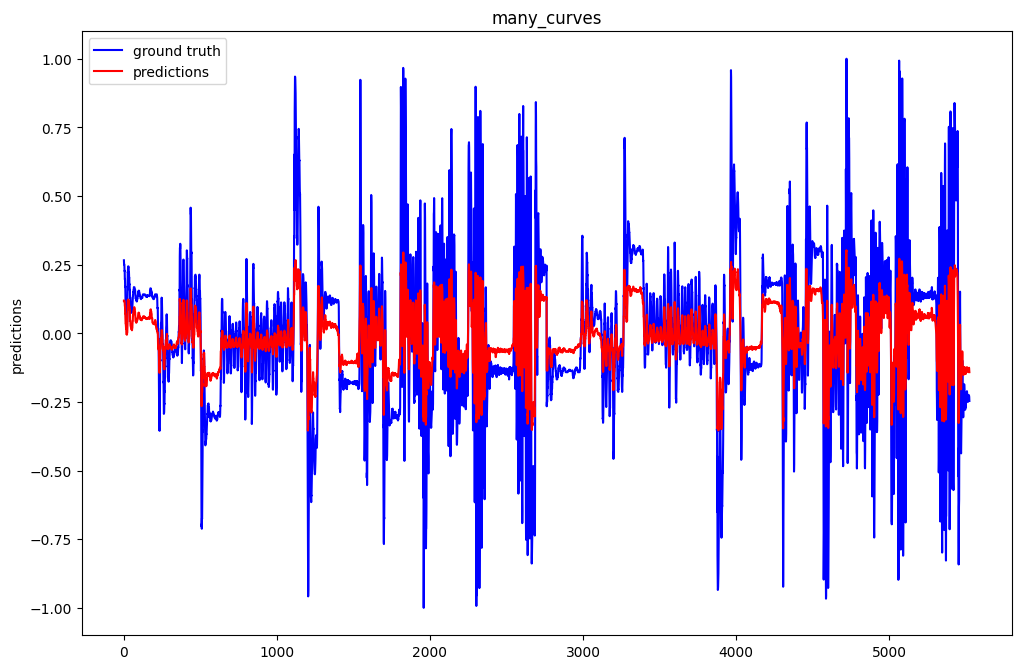

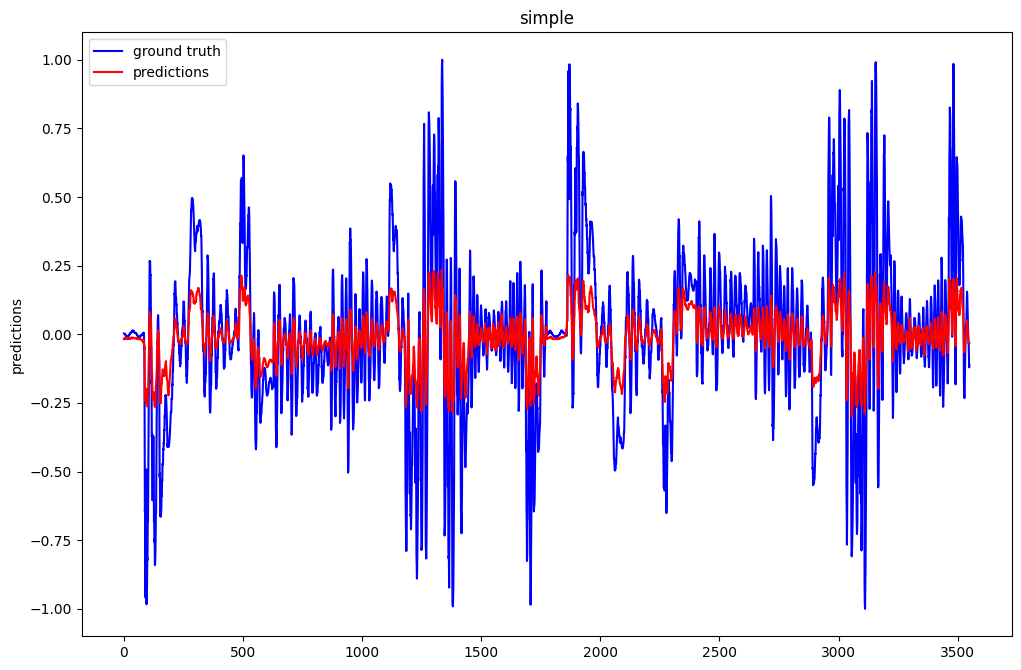

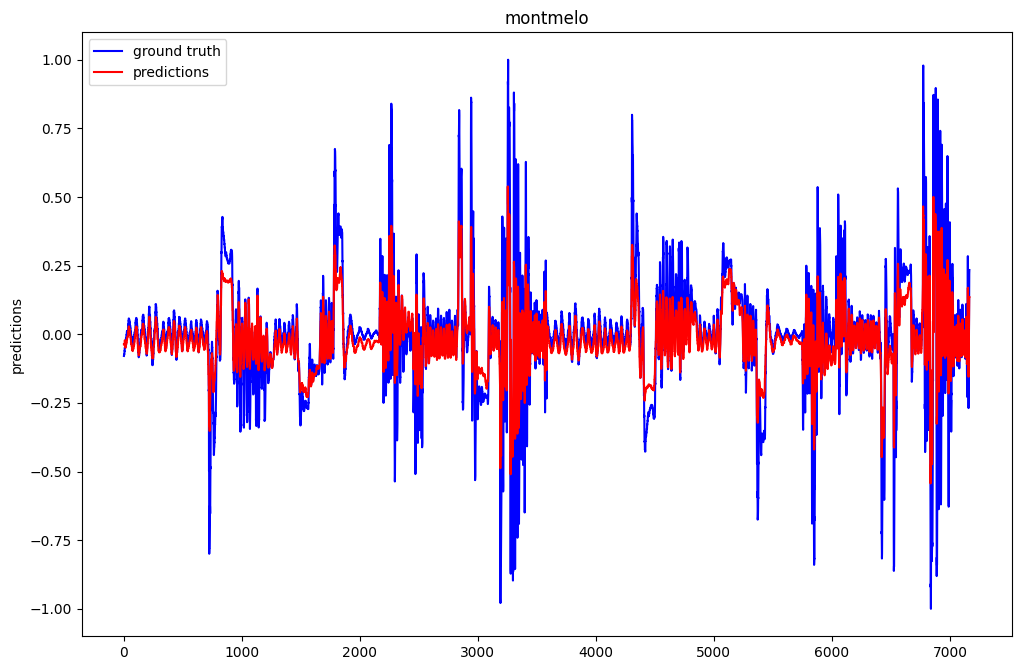

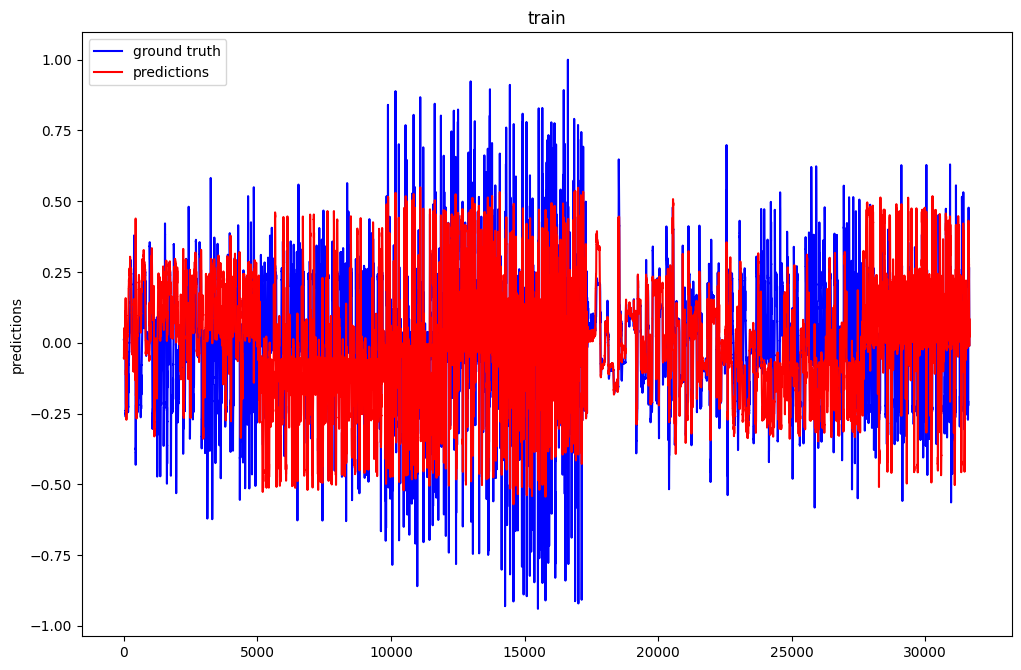

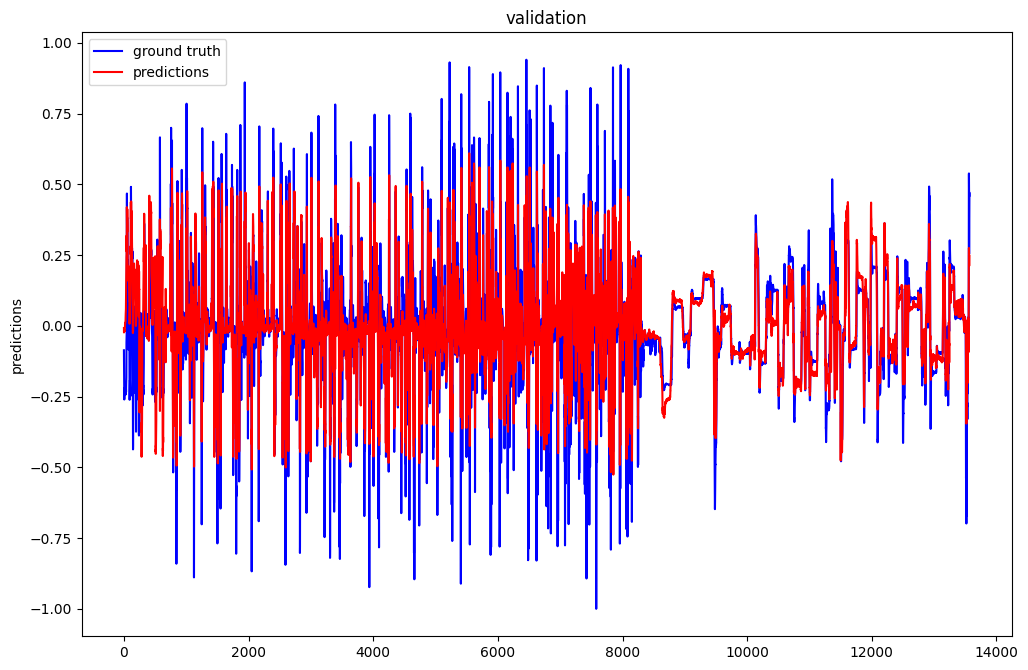

In [ ]:
import matplotlib.pyplot as plt

predictions_many_curves = deepest_lstm_tinypilotnet.predict(images_many_curves)
predictions_simple = deepest_lstm_tinypilotnet.predict(images_simple)
predictions_montmelo = deepest_lstm_tinypilotnet.predict(images_montmelo)
predictions_images_train = deepest_lstm_tinypilotnet.predict(images_train)
predictions_images_validation = deepest_lstm_tinypilotnet.predict(images_validation)

print(predictions_many_curves[0])
print(predictions_many_curves[:,1])

print(annotations_many_curves[0])
print(annotations_many_curves[:,1])

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_many_curves[:,1], "-b", label="ground truth")
plt.plot(predictions_many_curves[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('many_curves')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_simple[:,1], "-b", label="ground truth")
plt.plot(predictions_simple[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('simple')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_montmelo[:,1], "-b", label="ground truth")
plt.plot(predictions_montmelo[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('montmelo')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_train[:,1], "-b", label="ground truth")
plt.plot(predictions_images_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('train')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_validation[:,1], "-b", label="ground truth")
plt.plot(predictions_images_validation[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('validation')
plt.show()

[0.55941695 0.10974018]
[ 0.10974018  0.10974018  0.11073985 ... -0.04217284 -0.04750621
 -0.05625465]
[0.41176471 0.26590405]
[ 0.26590405  0.25026264  0.25026264 ... -0.22747753 -0.23177308
 -0.24657406]


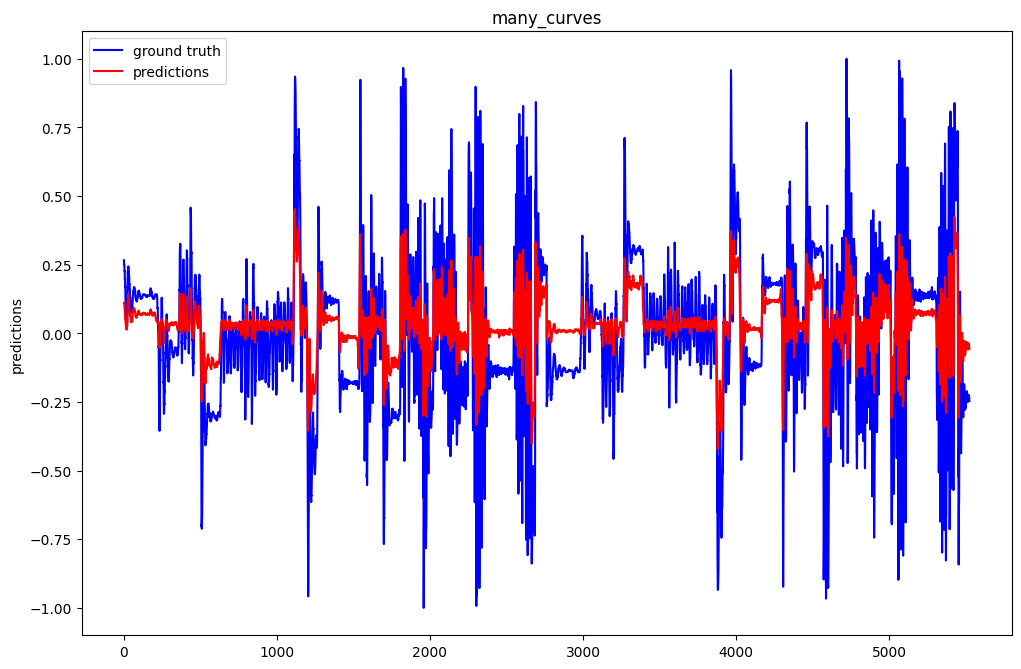

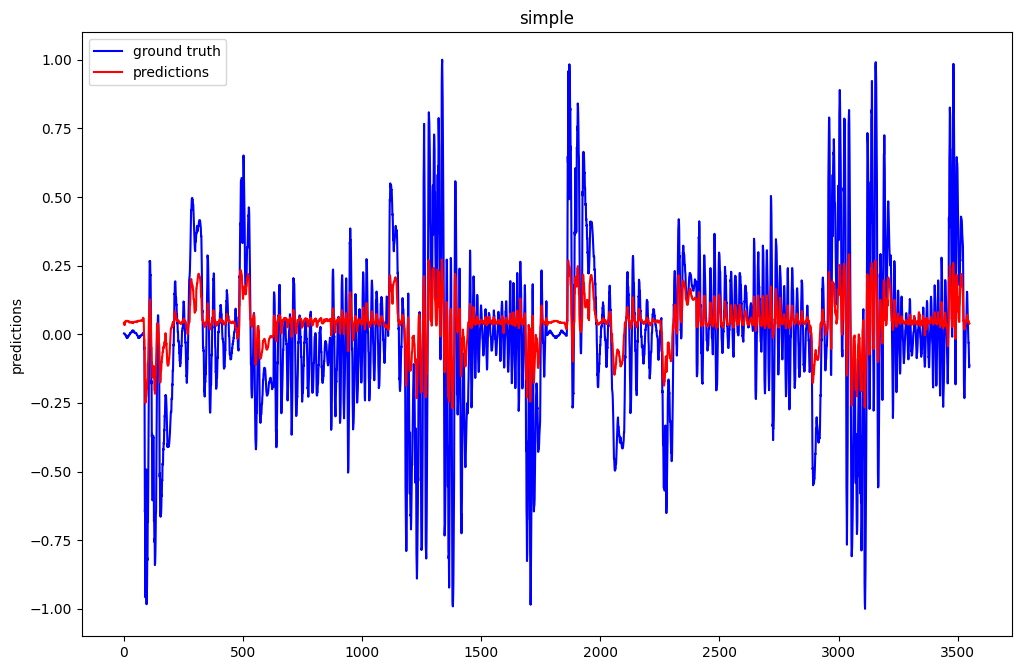

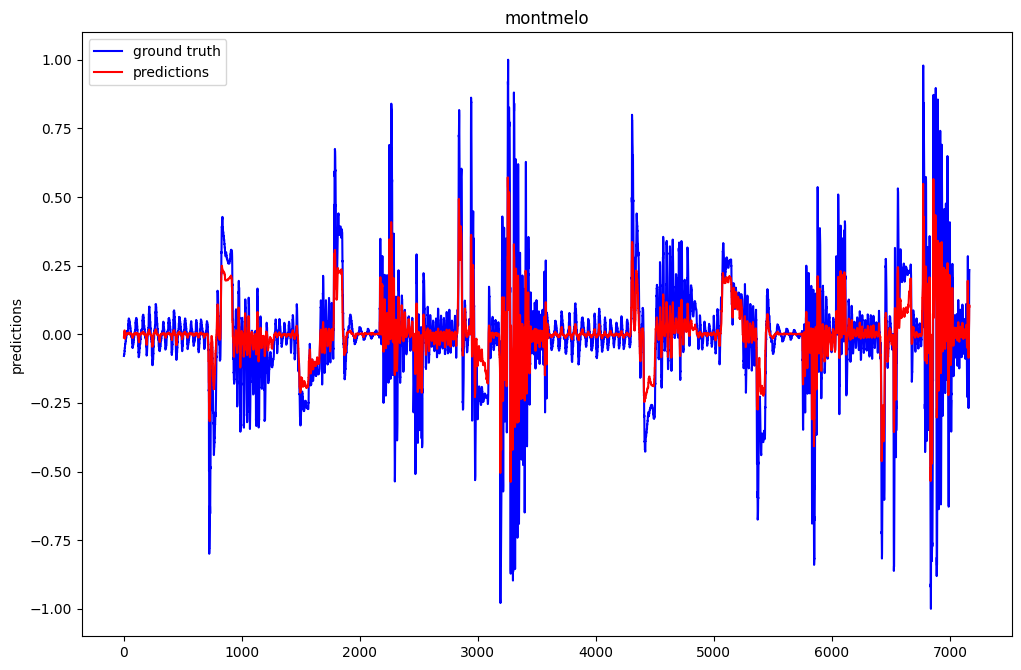

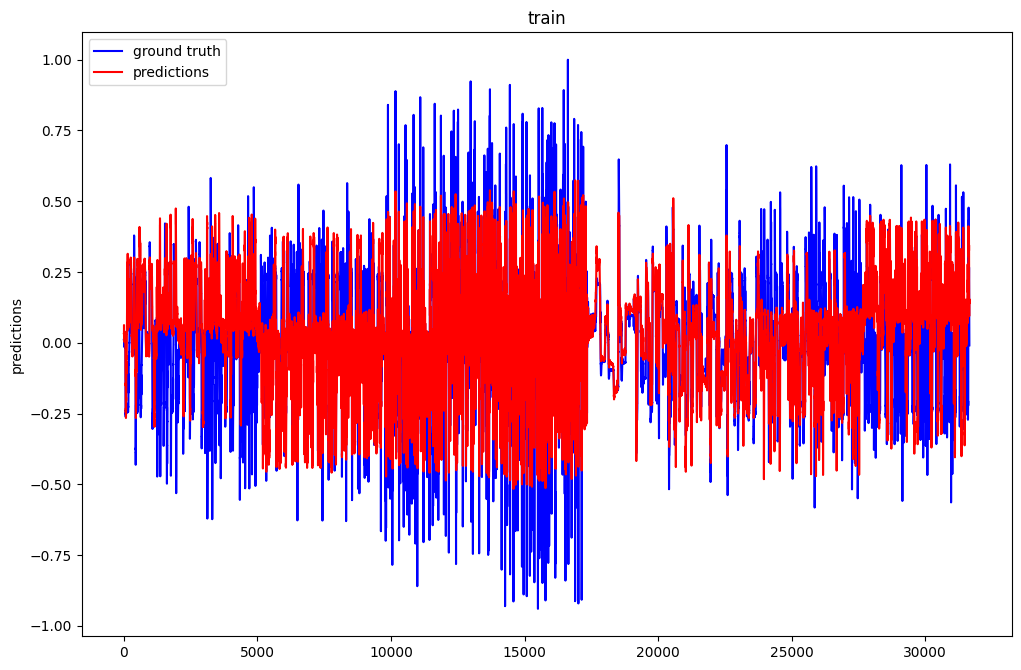

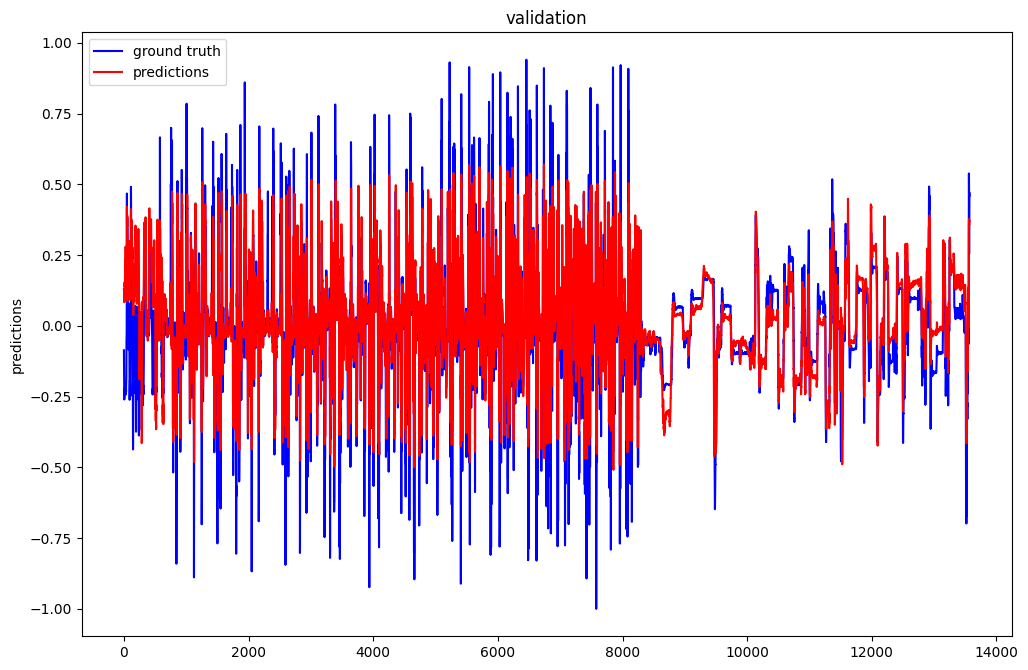

In [ ]:
import matplotlib.pyplot as plt

predictions_many_curves = deepest_lstm_tinypilotnet_2.predict(images_many_curves)
predictions_simple = deepest_lstm_tinypilotnet_2.predict(images_simple)
predictions_montmelo = deepest_lstm_tinypilotnet_2.predict(images_montmelo)
predictions_images_train = deepest_lstm_tinypilotnet_2.predict(images_train)
predictions_images_validation = deepest_lstm_tinypilotnet_2.predict(images_validation)

print(predictions_many_curves[0])
print(predictions_many_curves[:,1])

print(annotations_many_curves[0])
print(annotations_many_curves[:,1])

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_many_curves[:,1], "-b", label="ground truth")
plt.plot(predictions_many_curves[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('many_curves')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_simple[:,1], "-b", label="ground truth")
plt.plot(predictions_simple[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('simple')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_montmelo[:,1], "-b", label="ground truth")
plt.plot(predictions_montmelo[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('montmelo')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_train[:,1], "-b", label="ground truth")
plt.plot(predictions_images_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('train')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_validation[:,1], "-b", label="ground truth")
plt.plot(predictions_images_validation[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('validation')
plt.show()

[0.6885715  0.04965178]
[ 0.04965178  0.04965178  0.04900109 ... -0.18280117 -0.16708793
 -0.18908004]
[0.41176471 0.26590405]
[ 0.26590405  0.25026264  0.25026264 ... -0.22747753 -0.23177308
 -0.24657406]


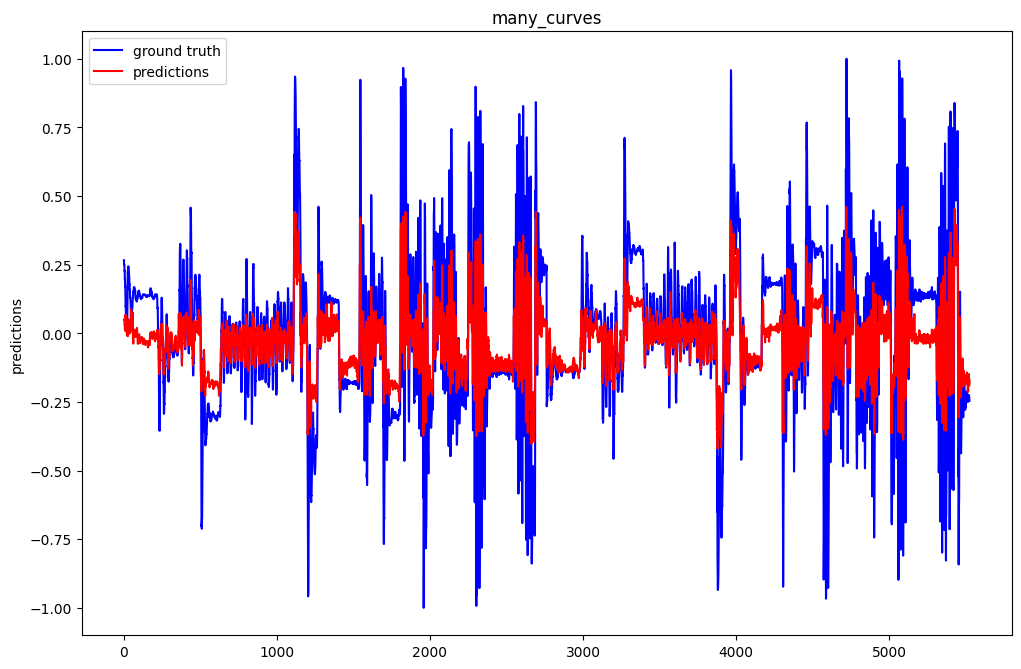

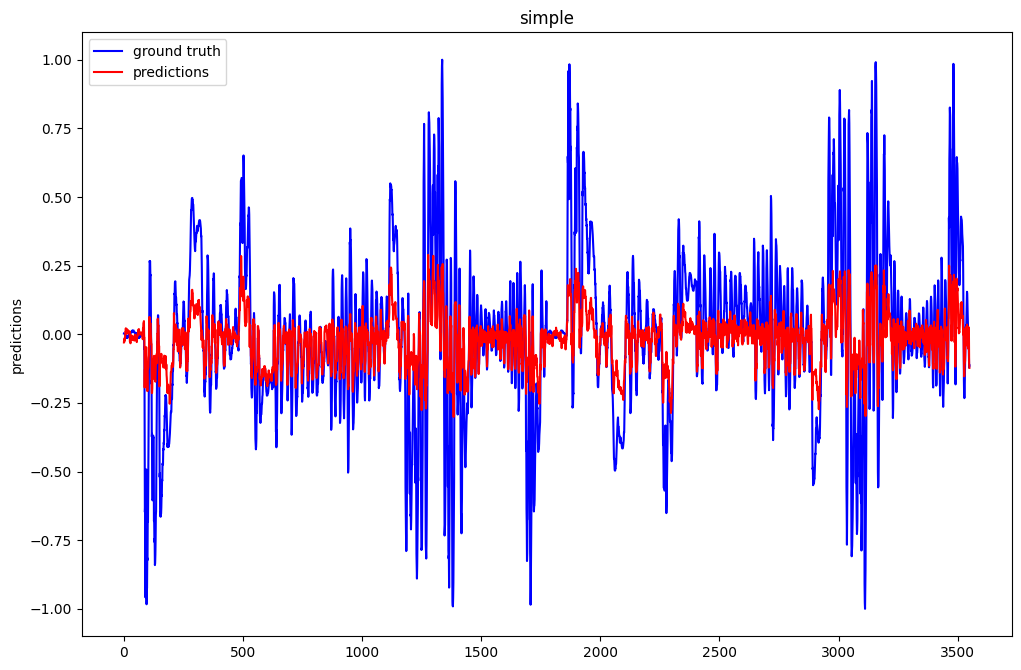

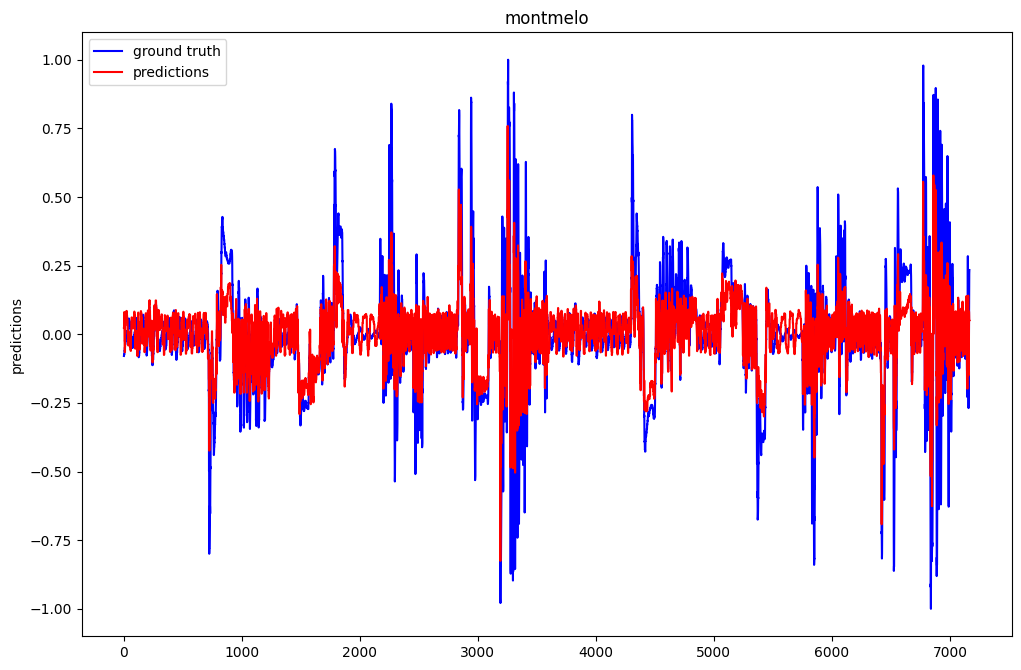

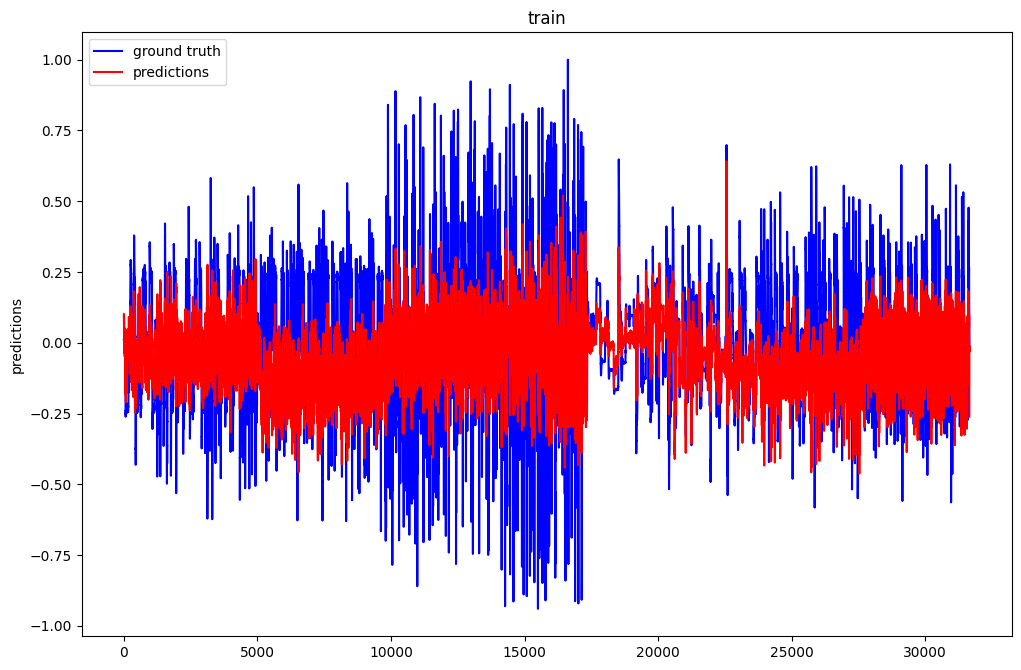

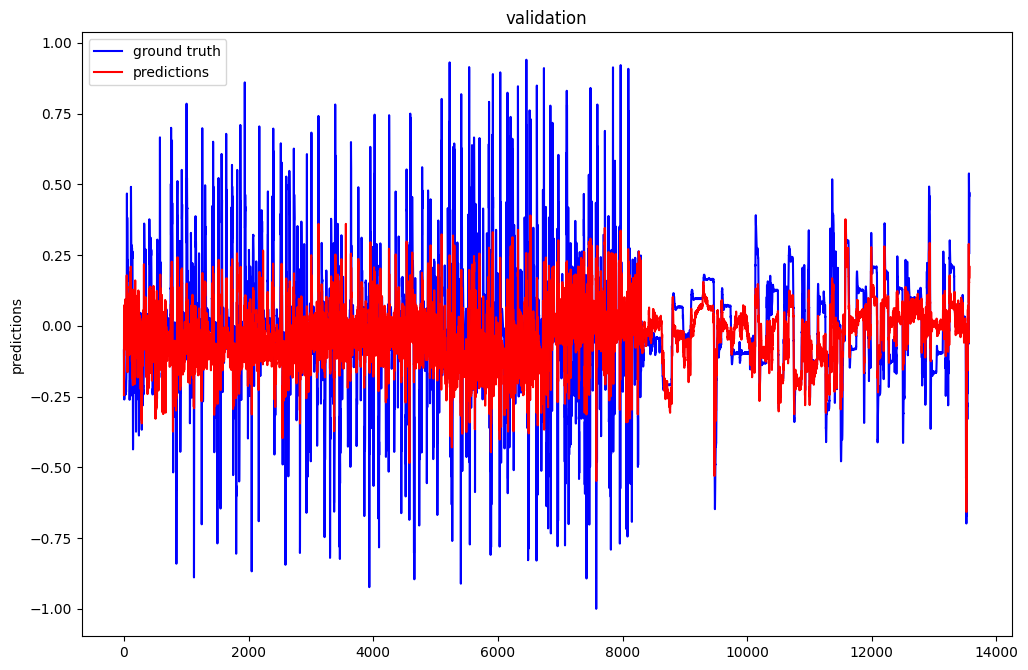

In [ ]:
import matplotlib.pyplot as plt

predictions_many_curves = lstm_tinypilotnet.predict(images_many_curves)
predictions_simple = lstm_tinypilotnet.predict(images_simple)
predictions_montmelo = lstm_tinypilotnet.predict(images_montmelo)
predictions_images_train = lstm_tinypilotnet.predict(images_train)
predictions_images_validation = lstm_tinypilotnet.predict(images_validation)

print(predictions_many_curves[0])
print(predictions_many_curves[:,1])

print(annotations_many_curves[0])
print(annotations_many_curves[:,1])

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_many_curves[:,1], "-b", label="ground truth")
plt.plot(predictions_many_curves[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('many_curves')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_simple[:,1], "-b", label="ground truth")
plt.plot(predictions_simple[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('simple')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_montmelo[:,1], "-b", label="ground truth")
plt.plot(predictions_montmelo[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('montmelo')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_train[:,1], "-b", label="ground truth")
plt.plot(predictions_images_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('train')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_validation[:,1], "-b", label="ground truth")
plt.plot(predictions_images_validation[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('validation')
plt.show()

[ 0.6734117  -0.01393146]
[-0.01393146 -0.01393146 -0.01346606 ... -0.04517094 -0.03167996
 -0.04096041]
[0.41176471 0.26590405]
[ 0.26590405  0.25026264  0.25026264 ... -0.22747753 -0.23177308
 -0.24657406]


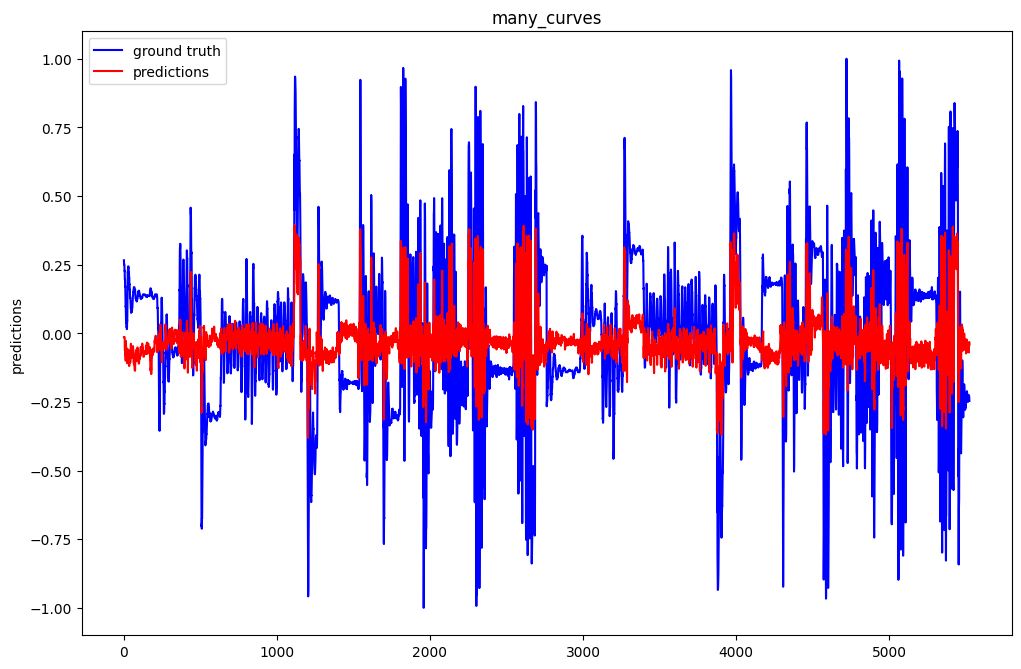

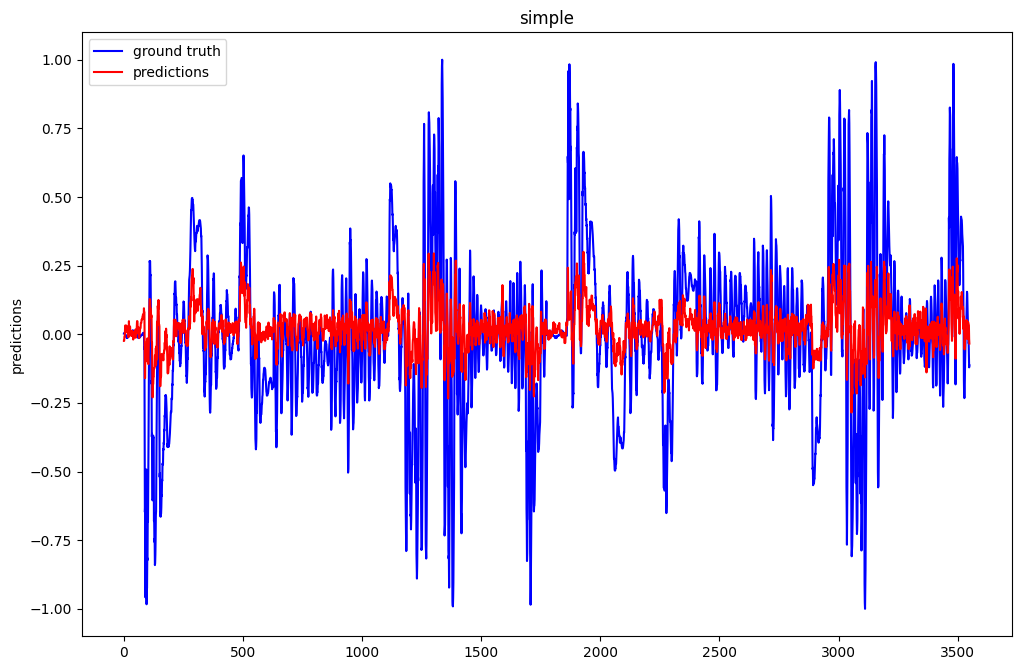

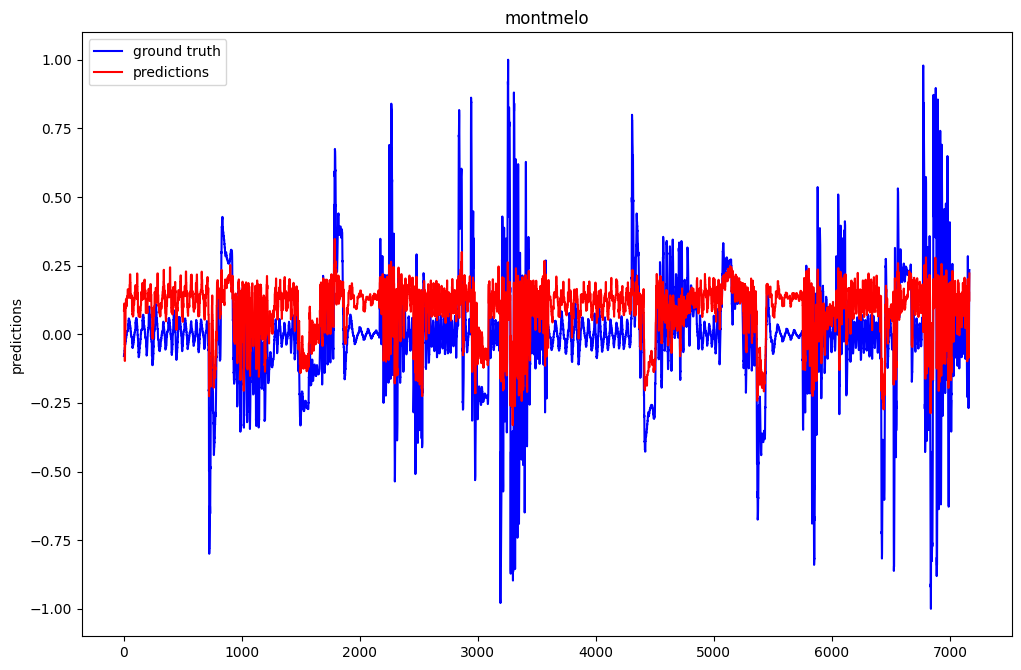

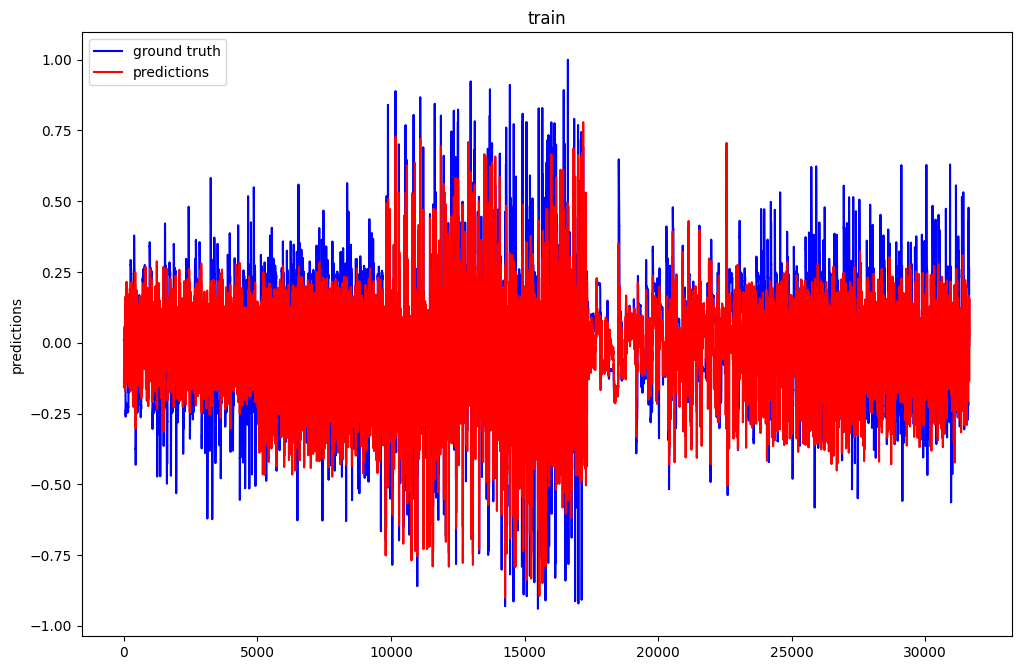

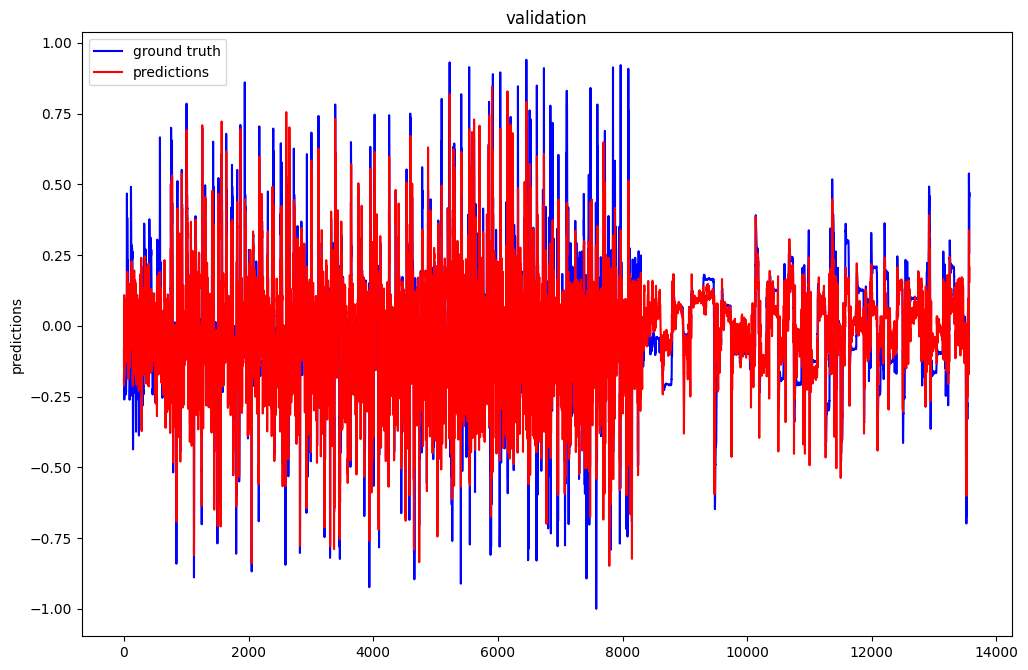

In [ ]:
import matplotlib.pyplot as plt

predictions_many_curves = tinypilotnet.predict(images_many_curves)
predictions_simple = tinypilotnet.predict(images_simple)
predictions_montmelo = tinypilotnet.predict(images_montmelo)
predictions_images_train = tinypilotnet.predict(images_train)
predictions_images_validation = tinypilotnet.predict(images_validation)

print(predictions_many_curves[0])
print(predictions_many_curves[:,1])

print(annotations_many_curves[0])
print(annotations_many_curves[:,1])

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_many_curves[:,1], "-b", label="ground truth")
plt.plot(predictions_many_curves[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('many_curves')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_simple[:,1], "-b", label="ground truth")
plt.plot(predictions_simple[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('simple')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_montmelo[:,1], "-b", label="ground truth")
plt.plot(predictions_montmelo[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('montmelo')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_train[:,1], "-b", label="ground truth")
plt.plot(predictions_images_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('train')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_validation[:,1], "-b", label="ground truth")
plt.plot(predictions_images_validation[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('validation')
plt.show()

[0.40987876 0.12350957]
[ 0.12350957  0.12350957  0.12418441 ... -0.1455673  -0.1649675
 -0.17304018]
[0.41176471 0.26590405]
[ 0.26590405  0.25026264  0.25026264 ... -0.22747753 -0.23177308
 -0.24657406]


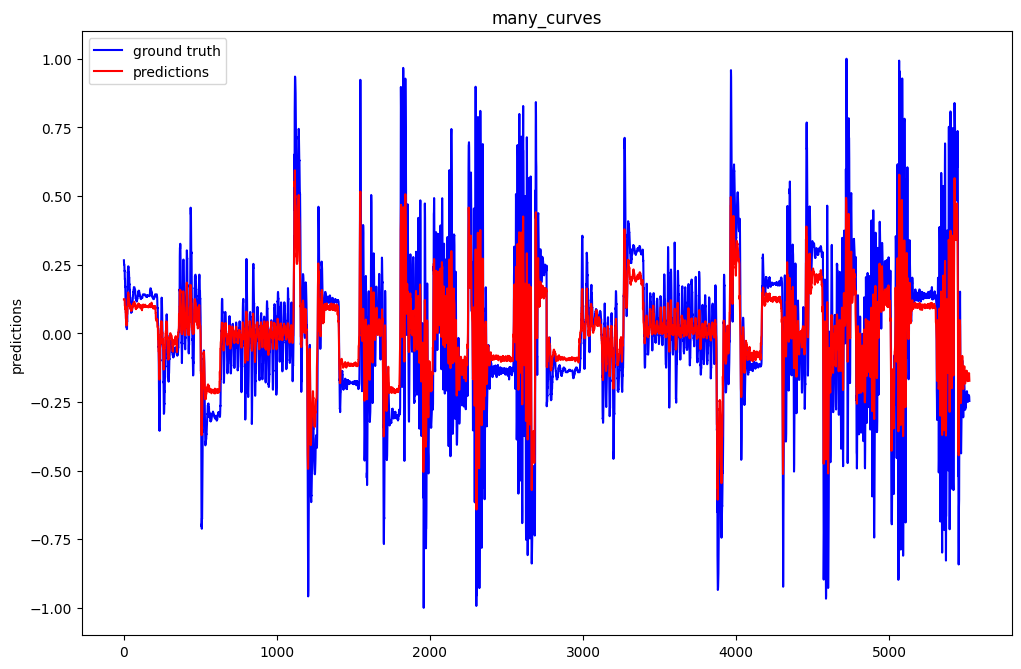

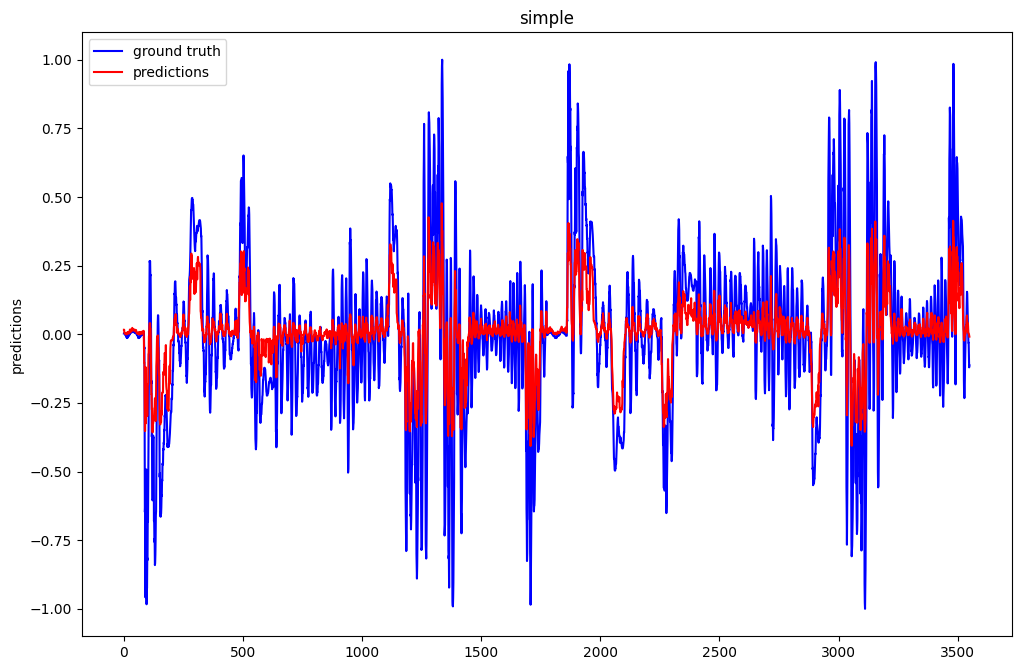

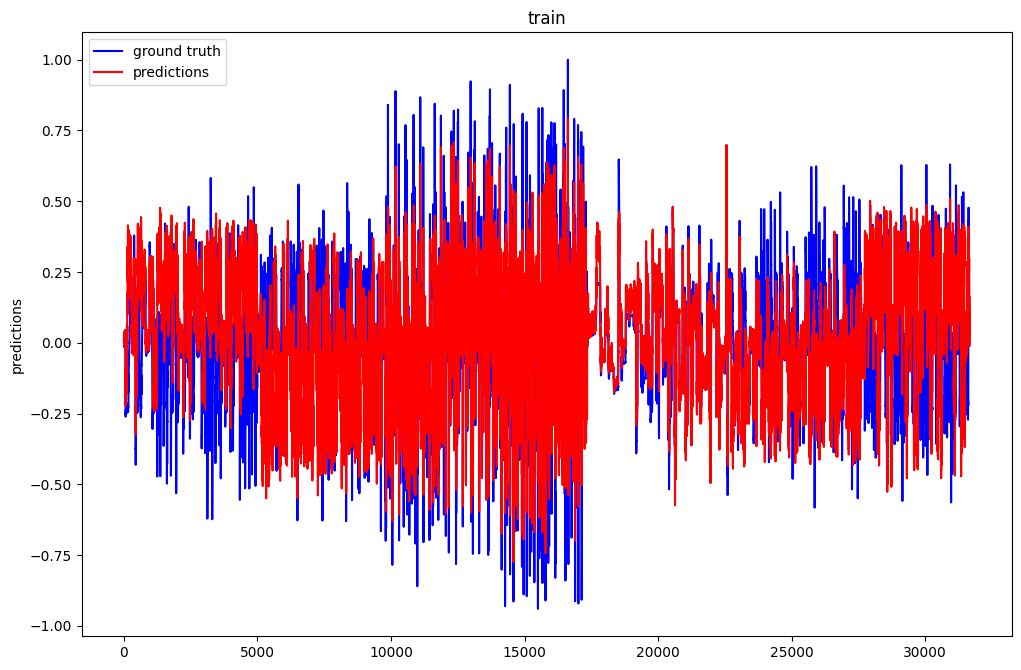

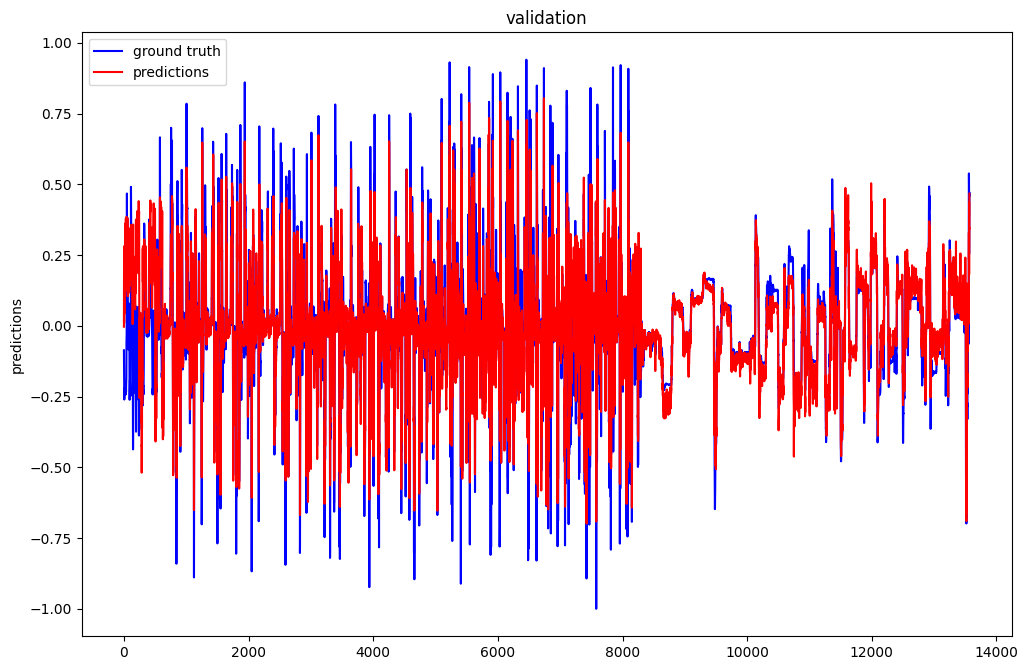

In [ ]:
import matplotlib.pyplot as plt

predictions_many_curves = pilotnet.predict(images_many_curves)
predictions_simple = pilotnet.predict(images_simple)
predictions_montmelo = pilotnet.predict(images_montmelo)
predictions_images_train = pilotnet.predict(images_train)
predictions_images_validation = pilotnet.predict(images_validation)

print(predictions_many_curves[0])
print(predictions_many_curves[:,1])

print(annotations_many_curves[0])
print(annotations_many_curves[:,1])

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_many_curves[:,1], "-b", label="ground truth")
plt.plot(predictions_many_curves[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('many_curves')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_simple[:,1], "-b", label="ground truth")
plt.plot(predictions_simple[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('simple')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_montmelo[:,1], "-b", label="ground truth")
plt.plot(predictions_montmelo[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('montmelo')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_train[:,1], "-b", label="ground truth")
plt.plot(predictions_images_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('train')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_validation[:,1], "-b", label="ground truth")
plt.plot(predictions_images_validation[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('validation')
plt.show()